In [0]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Grover's Algorithm



---

## Overview

This notebook demonstrates Grover's algorithm applied to an example of searching for 2 marked items in a small unsorted database. Grover's algorithm illustrates patterns and structure that are also used in other quantum algorithms, such as:

- [Deutsch-Jozsa algorithm](https://nvidia.github.io/cuda-quantum/latest/applications/python/deutsch_jozsa.html) (distinguishing constant from balanced functions)
- Simon’s algorithm (finding hidden periodicity)
- [Shor’s algorithm](https://nvidia.github.io/cuda-quantum/latest/applications/python/shors.html) (factoring via [quantum Fourier transform](https://nvidia.github.io/cuda-quantum/latest/applications/python/quantum_fourier_transform.html)).

For more explanations of Grover's algorithm, check out the CUDA-Q Academic resources. INSERT LINK

Before we get started, we will need to import a few libraries:


In [4]:
import cudaq
import matplotlib.pyplot as plt
import numpy as np


---

## Problem

We consider the problem of searching for a marked element or a set of marked elements in an unstructured database. We can make this explicit by considering a database made up of binary strings of length $n$. Let $\mathbb{B}^n$ denote the set of binary strings of length $n$.  A Boolean function
$$f: \mathbb{B}^n
\to \{0,1\}$$
encodes the marked elements, where $f(x) =1$ if $x$ is a marked string. Our goal is to find all strings $x$ such that $f(x) = 1$.

Classically, if we have no prior knowledge about $f$ (i.e., it is given as a black-box oracle), the best strategy requires $O(N)$ evaluations, where $N = 2^n$ is the total number of binary strings. However, there exists a quantum algorithm due to L. Grover that finds a solution using only $O(\sqrt{N})$ oracle queries  ([Grover, 1996](https://arxiv.org/abs/quant-ph/9605043)).  

We will use computational basis states on $n$ qubits to represent the $2^n$ elements in the database $B^n$.  Our goal is to create a quantum kernel that separates the marked states from the non-marked states. That is, sampling from the kernel yields a marked state with high probability and a non-marked state with low probability.  





In this notebook, we will use a specific example to illustrate the steps and key concepts of Grover's algorithm. 

Let $n=4$ and mark the states `1001` and `1111`.  



---

## Structure of Grover's Algorithm

Grover's Algorithm can be broken down into the following steps:

1. Preparation: Initialize $n$ qubits in an equal superposition state and initialize an auxiliary qubit in the minus state.
2. Oracle Application: Apply an oracle to mark the desired states by flipping their phase.
3. Amplitude Amplification: Use a diffusion operator to amplify the amplitudes of the marked states.
4. Iteration: Repeat Steps 2 and 3 a specified number of times, which depends on the number of marked elements and $n$. 
5. Measurement: Measure the qubits. With high probability, the result will be one of the marked states.


We will describe each of these steps in detail. Between Step 1 and Step 2, we will introduce two quantum states (the good and the bad state) and their geometric interpretation that will help motivate Steps 3 and 4.


### Step 1: Preparation
The first step of Grover's algorithm requires initializing $n$ qubits and one auxilary qubit.  The auxilary qubit is initialized in the minus state.
We apply the $H$ gate to the remaining qubits to initialize them in an equal superposition of all possible binary strings.  We'll refer to this state as $|\xi\rangle$.

$$
\ket{\xi}:= H^{\otimes n} (|0\rangle^{\otimes n}) = \frac{1}{\sqrt{N}} \sum\limits_{i=0}^{N-1} |i\rangle,
$$
where each binary string is identified with the integer it represents (e.g., $|5\rangle = |0101\rangle$).

The kernels in the code block below carries out this step.


In [5]:
# Kernel to initialize the auxiliary qubit in the minus state
@cudaq.kernel
def minus_state(aux_qubit_in_zero_state : cudaq.qview):
    x(aux_qubit_in_zero_state)
    h(aux_qubit_in_zero_state)

# Kernel to create an equal superposition state of qubits initialized to |0>
@cudaq.kernel
def equal_superposition(qubits_in_zero_state : cudaq.qview):
    h(qubits_in_zero_state)  

### Good and Bad States

We can simplify our analysis of Grover's Algorithm by focusing on two useful quantum states, which we'll refer to as the "good" and "bad" states.  The "good" state captures the marked bitstrings and the "bad" state is orthogonal to the "good" state.

Suppose there are $t$ marked states, i.e., there are $t$ elements $x \in \mathbb{B}^n$ with $f(x) = 1$. Letting $N=2^n$, we introduce the following quantum states:

$$
|G\rangle := \frac{1}{\sqrt{t}} \sum\limits_{i, f(i) = 1} |i\rangle, \quad |B\rangle := \frac{1}{\sqrt{N - t}} \sum\limits_{i, f(i) = 0} |i\rangle.
$$

These are the uniform superpositions of marked and unmarked states, referred to as the "good" and "bad" states, respectively.  

Rewriting the uniform superposition state $\ket{\xi}$ in terms of $|G\rangle$ and $|B\rangle$, we obtain:

$$
\ket{\xi} = \frac{1}{\sqrt{N}} \sum\limits_{i, f(i) = 1} |i\rangle + \frac{1}{\sqrt{N}} \sum\limits_{i, f(i) = 0} |i\rangle
= \frac{\sqrt{t}}{\sqrt{N}} |G\rangle + \frac{\sqrt{N - t}}{\sqrt{N}} |B\rangle.
$$





Let's see what this look likes for our example of $n=4$ and marked states `1001` and `1111`.  Here $\ket{\xi} = \frac{1}{16}\sum_{k=0}^{15}\ket{k}$ since there are 4 qubits and 16 computational basis states with $\ket{0} = \ket{0000}, \ket{1} = \ket{0001}, \cdots \ket{15} = \ket{1111}$.  The good state is a equal superposition of the states $\ket{9} =\ket{1001}$ and $\ket{15} =\ket{1111}$: 
$$\ket{G} =  \frac{1}{\sqrt{2}}(\ket{9}+\ket{15} )= \frac{1}{\sqrt{2}}(\ket{1001}+\ket{1111}).$$

The bad state is an equal superposition of the remaining states:
$$\ket{B} = \frac{1}{\sqrt{14}}(\ket{0}+\ket{1}+\ket{2}+\cdots+\ket{8}+\ket{10}+\cdots+\ket{14}) = \frac{1}{\sqrt{14}}\sum_{x\in B^4}f(x)\ket{x}. $$

Notice that $\ket{G}$ and $\ket{B}$ are orthogonal. 



Next, we observe that the coefficients $\frac{\sqrt{t}}{\sqrt{N}}$ and $\frac{\sqrt{N - t}}{\sqrt{N}}$ are real numbers satisfying:

$$
\left(\frac{\sqrt{t}}{\sqrt{N}}\right)^2 + \left(\frac{\sqrt{N - t}}{\sqrt{N}}\right)^2 = 1.
$$

This naturally leads us to apply a trigonometry identity to define an angle $\theta$ such that:

$$
\theta = \arcsin\left(\frac{\sqrt{t}}{\sqrt{N}}\right).
$$

With this notation, we can rewrite $\ket{\xi}$ as:

$$
\ket{\xi} = \sin(\theta) |G\rangle + \cos(\theta) |B\rangle.
$$



For our example, we have 2 marked states and 4 qubits, in other words $t =2$ and $ N = 2^4 = 16$.
In this case,  $\theta = \arcsin(\frac{\sqrt{2}}{\sqrt{16}}) = \arcsin(\frac{1}{\sqrt{8}}))\approx 21^\circ$.  

Let us now examine the geometric picture behind our current discussion. We'll consider the ambient Hilbert space to be spanned by the standard basis vectors $|0\rangle, |1\rangle, \dots, |N-1\rangle$, where the full dimension is $N = 2^n$. Since the uniform superposition state $|\xi\rangle$ can be expressed as a linear combination of the states $|G\rangle$ and $|B\rangle$ with real coefficients, all three states $|\xi\rangle, |G\rangle,$ and $|B\rangle$ reside in a two-dimensional real subspace of the ambient Hilbert space, which we can visualize as a 2D plane as in the image below.  Since, $|G\rangle$ and $|B\rangle$ are orthogonal, we can imagine them graphed as unit vectors in the positive $y$ and positive $x$ directions, respectively.  From our previous expression, $\ket{\xi} = \sin(\theta) |G\rangle + \cos(\theta) |B\rangle,$ we see that the state $|\xi\rangle$ forms an angle $\theta$ with $|B\rangle$.

<div style="text-align: center;">
    <img src="grovers-2D-plane.png" style="width: 20%;">
</div>

Given that the number of marked states $t$ is typically small compared to $N$, it follows that $\theta = \arcsin\left(\sqrt{\frac{t}{N}}\right)$is a small angle. This assumption is reasonable, as otherwise, a sufficient number of independent queries to the oracle would likely yield a solution through classical search methods.




### Step 2: Oracle application





After we have created a state of equal superposition, the good state is marked by flipping its phase.  This is done with a **phase oracle**.  A phase oracle $U$ is a unitary operation that has the property that for a computational basis state $\ket{x}$

$$
U |x\rangle = 
\begin{cases} 
-|x\rangle & \text{if } |x\rangle \text{ is marked} \\
|x\rangle & \text{if } |x\rangle \text{ is not marked}
\end{cases}
$$

In order to implement $U$ we need an auxillary qubit initialized in the $\ket{-}$ state.



Let's consider our example of the two marked states $\ket{9} =\ket{1001}$ and $\ket{15} =\ket{1111}$.  We'll first write a unitary matrix $U_{15}$ that flips the computational basis state $\ket{15}$ but keeps all other computational basis states fixed.  Notice that applying a controlled-$Z$ gate to a qubit pair in which the target is in the $|-\rangle$ state and the control is in the $|1\rangle$ state will filp the phase of the control qubit.  This is referred to as phase kickback, and we'll use it in our definition of $U_{15}$ and $U_9$ below.



In [6]:
# Define U_15 so that U_15|1111> = -|1111> but fixes 
# all other computational basis states |x>

# Set the number of qubits for the computational basis states
num_qubits = 4


# Using phase kickback, apply a multi-controlled Z gate
# with the auxiliary qubit as the target and all other qubits
# as the control
@cudaq.kernel
def U15(qubits: cudaq.qvector, aux_qubit: cudaq.qubit):
    z.ctrl(qubits, aux_qubit)

# Define U_9 so that U_9|1001> = -|1001> but fixes 
# all other computational basis states |x>
    
# By wrapping the U15 kernel with x gates applied to 
# qubits 1 and 2 we're able to mark the state |1001> similarly
@cudaq.kernel
def U9(qubits: cudaq.qvector, aux_qubit: cudaq.qubit):
    
    x(qubits[1])
    x(qubits[2])
    U15(qubits, aux_qubit)
    x(qubits[1])
    x(qubits[2])

# Define a phase oracle that flips the phase of both 1111 and 1001, fixing all other computational basis states
# assuming that the aux_qubit is initialized in the minus state
@cudaq.kernel
def phase_oracle(qubits: cudaq.qvector, aux_qubit: cudaq.qubit):
    U9(qubits, aux_qubit)
    U15(qubits, aux_qubit)

### Step 3: Amplitude amplification



The main idea behind Grover's algorithm is to construct an operator that performs a clockwise rotation by $2\theta$ in the two-dimensional plane spanned by the state vectors $|G\rangle$ and $|B\rangle$. This is carried out through a composition of two rotations.  First $|\xi\rangle$ is reflected over $|B\rangle$ (by a rotation operation $r_B$) and then this state is reflected over $|\xi\rangle$ by a rotation operation $r_\xi$, as depicted in the animation below.

![](https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/refs/heads/main/images/grovers.gif)



#### Reflecting over the |0000&gt; State

Before defining $r_\xi$, we'll first define a gate sequence that will reflect a state over the all zero state.

For \( n = 4 \), the reflection operator  
$$
r_0 = 2 |0^{\otimes 4} \rangle \langle 0^{\otimes 4} | - \text{Id}
$$
acts as the identity on $|0000\rangle $ and multiplies all other computational basis states by $ -1 $.

This is coded in the cell block below.

In [7]:
# Reflection about the all zero state

@cudaq.kernel
def all_zero_reflection(qubits: cudaq.qview):
    num_qubits = len(qubits)
    z(qubits[0])
    x(qubits[0])
    z(qubits[0])
    x(qubits[0])
    x(qubits)    
    z.ctrl(qubits[0:num_qubits-1], qubits[num_qubits-1])
    x(qubits)


#### Reflecting over the equal superposition state

Now let's adapt the `all_zero_reflection` to instead reflect about the equal superposition state.  To do this we'll wrap the `all_zero_reflection` kernel with Hadamard gates which will transform the qubits from the equal superposition state to the all zero state and back.



In [8]:
# Reflection about the equal superposition state

# Wrap the all_zero_reflection kernel with hadamard gates applied to the n qubits
@cudaq.kernel
def reflection_about_xi(qubits : cudaq.qview):
    h(qubits)
    all_zero_reflection(qubits)
    h(qubits)

Now that we've defined $r_\xi$, we're only left with defining $r_B$.  But we've actually already done that! Notice that the controlled-phase oracle that we discussed earlier has the effect of reflecting the state $\ket{\xi}$ over the state $\ket{B}$, which is exactly what we need for $r_B$.

#### Completing Step 3


We are now able to realize the iterated operator in Grover's algorithm, which we will denote by $\mathcal{G}$.

$$
\mathcal{G} = r_\xi \circ r_B = H^{\otimes n} \big( 2|0^{\otimes n} \rangle \langle 0^{\otimes n}| - \text{Id} \big) H^{\otimes n} \mathcal{O}_f.
$$
The circuit diagram below puts together steps 1 through 3:
<div style="text-align: center;">
    <img src="grovers-steps1-3.png" style="width: 50%;">
</div>

Running this circuit  initializes $\ket{\xi}$ and performs a rotation by $2\theta$ \(twice the angle between $|\xi\rangle$ and $|B\rangle$\) in the direction from $|B\rangle$ to $|G\rangle$.

<div style="text-align: center;">
    <img src="grovers-full-rotation.png" style="width: 25%;">
</div>

Recall that in our example the state $\ket{\xi}$ is approximately $21^\circ$ away from $\ket{B}$. Let's verify that the state resulting from one iteration of Grover's algorithm is $90^\circ
-3\theta\approx 27^\circ$ away from $\ket{G}$.  Moreover, notice that the amplitudes of `1001` and `1111` in the resulting state have been amplified compared to the equal superposition of states.


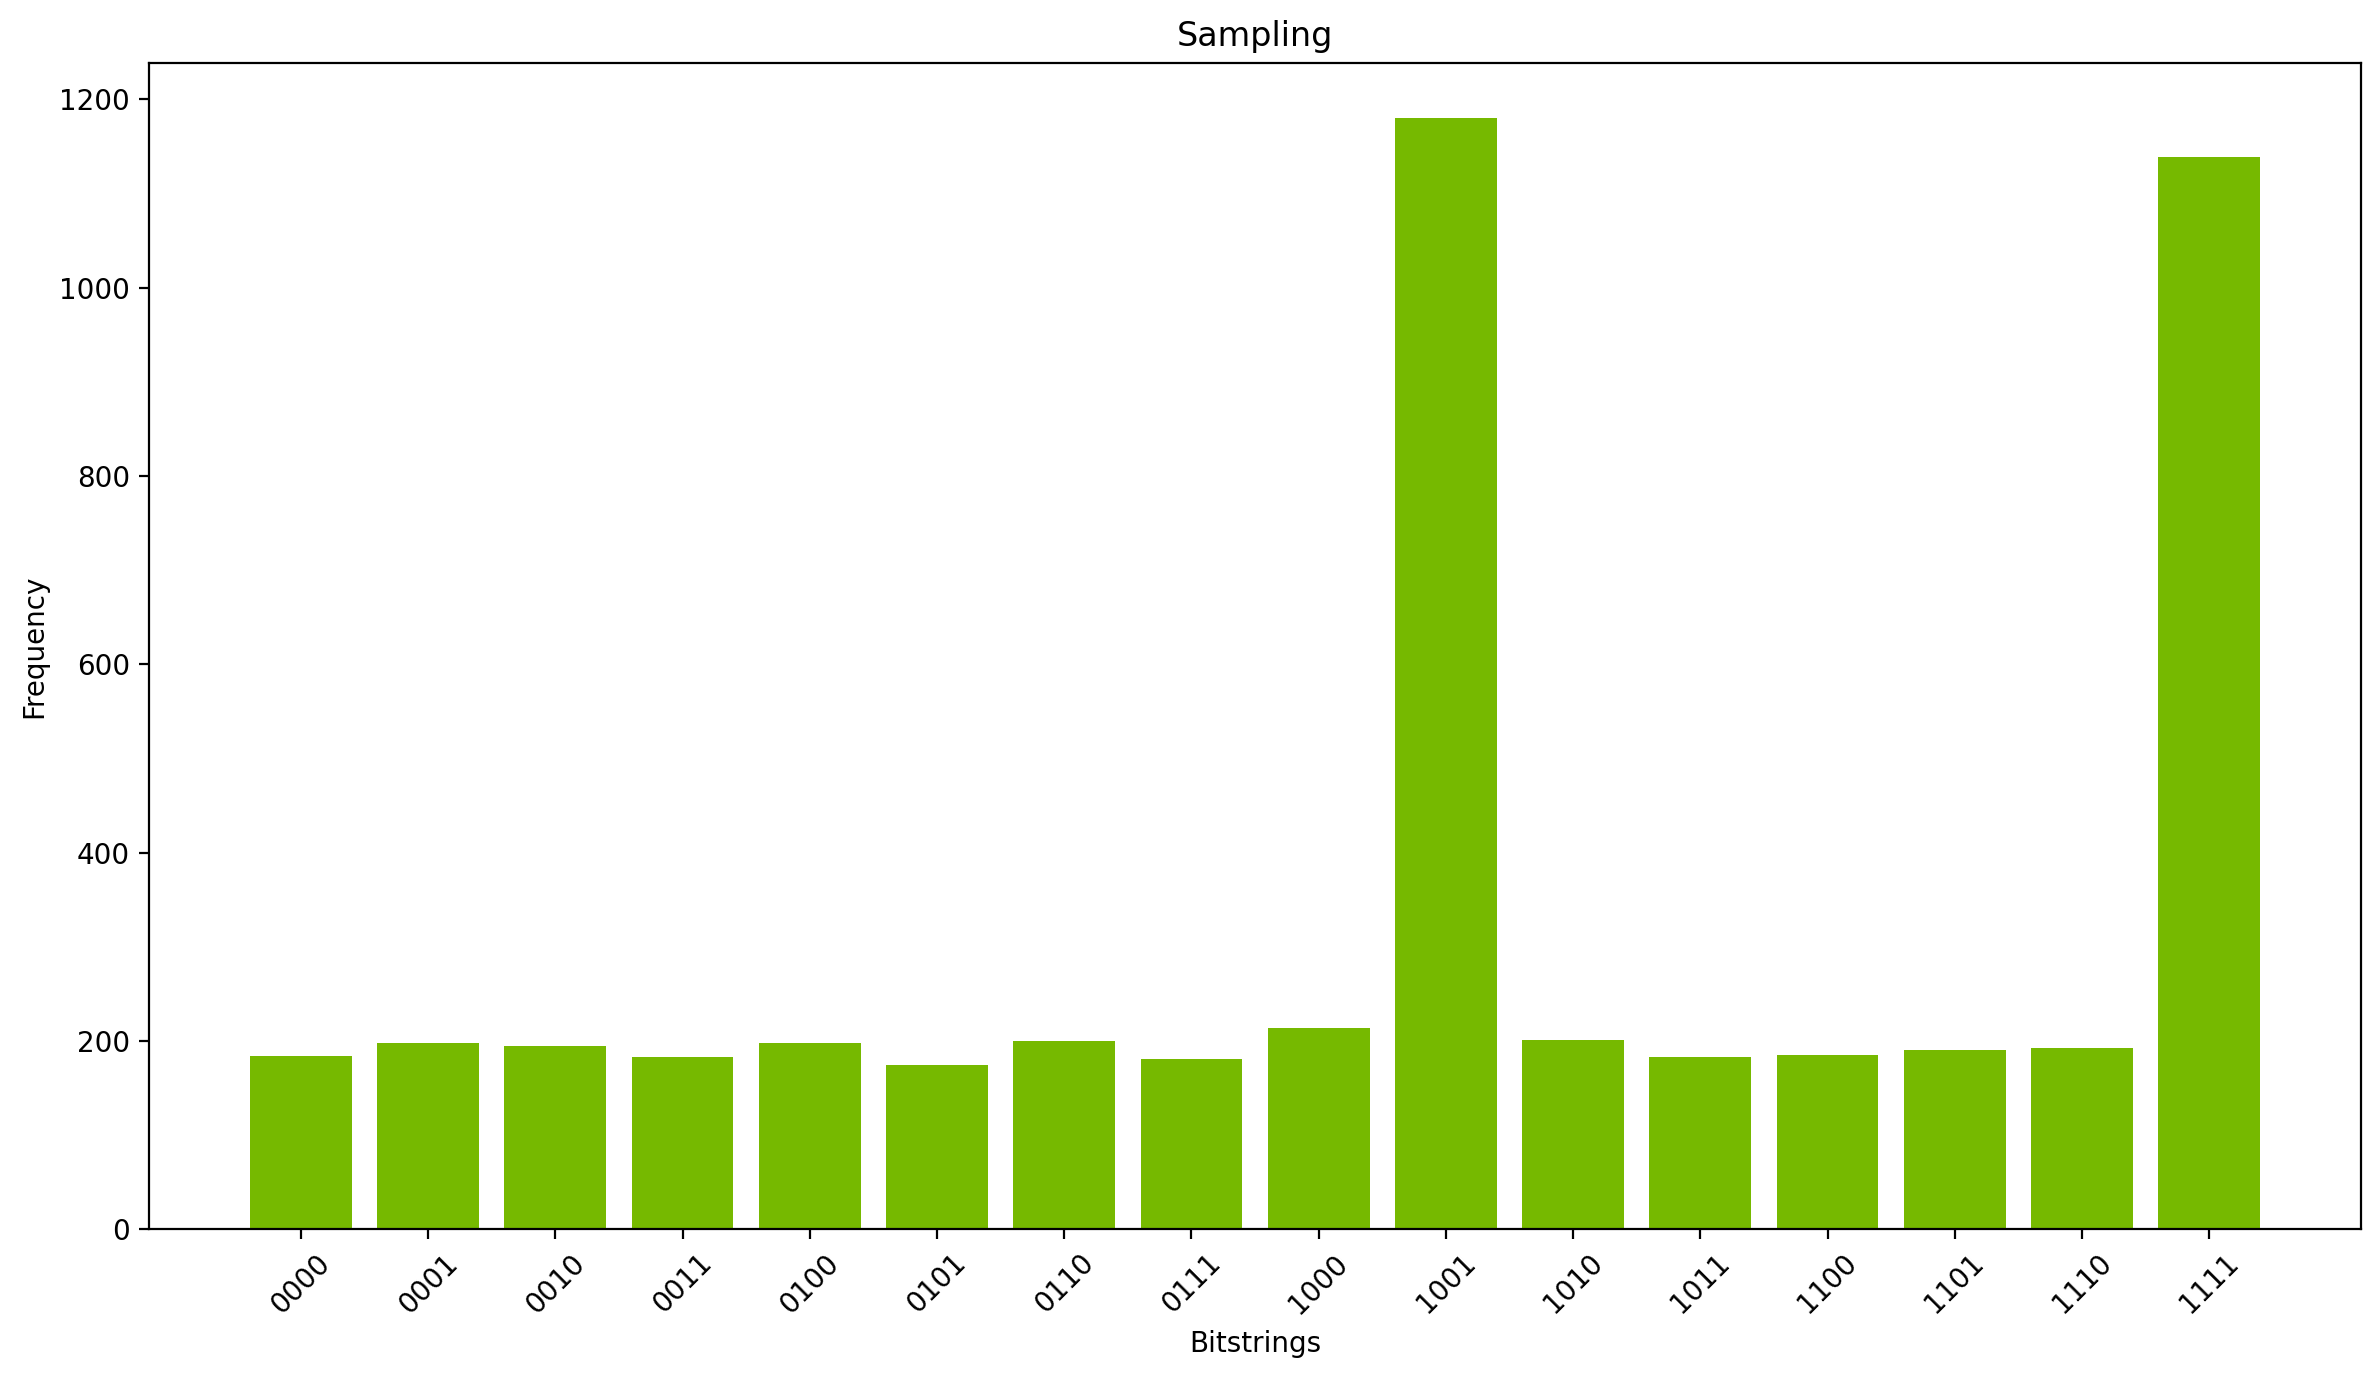

The angle between the resulting state and the good state
 after one iteration of the circuit is  47.07800576585969


In [9]:
# Define the Grover diffusion operator

@cudaq.kernel
def diffusion_operator(qubits: cudaq.qview):

    # Apply Hadamard gates
    h(qubits)
    # Apply rotation about the all zero state
    all_zero_reflection(qubits)
    # Apply Hadamard gates
    h(qubits)

num_qubits = 4    

# Apply the Grover diffusion operation to the equal superposition state
@cudaq.kernel
def one_iteration(num_qubits: int):
    qubits = cudaq.qvector(num_qubits)
    aux_qubit =cudaq.qubit()
    # Initialize qubits in an equal superposition state
    equal_superposition(qubits)
    # Initialize the auxillary qubit in the minus state
    x(aux_qubit)
    h(aux_qubit)
    # Apply the phase oracle once
    phase_oracle(qubits, aux_qubit)
    # Apply one iteration of the diffusion operator
    diffusion_operator(qubits)
    
    # Measure all qubits, except the auxillary qubit
    mz(qubits)

# Sample 
sample_result = cudaq.sample(one_iteration, num_qubits, shots_count = 5000)


# Plot the histogram of sampling results

# Define a function to draw the histogram of the results of sampling a kernel
def plot_results(result, num_qubits):
    # Define a dictionary of results 

    # Initialize the dictionary with all possible bit strings of length 4 for the x axis
    result_dictionary = {}

    # Generate all possible bit strings of length num_qubits
    for i in range(2**num_qubits):
        bitstr = bin(i)[2:].zfill(num_qubits)
        result_dictionary[bitstr] = 0

    # Update the results dictionary of results from the circuit sampling
    for k,v in result.items():
        result_dictionary[k] = v

    # Convert the dictionary to lists for x and y values
    x = list(result_dictionary.keys())
    y = list(result_dictionary.values())

    # Create the histogram
    plt.bar(x, y, color='#76B900')

    # Add title and labels
    plt.title("Sampling")
    plt.xlabel("Bitstrings")
    plt.ylabel("Frequency")

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_results(sample_result, num_qubits)

print(sample_result.items())

# compute the angle between the resulting state and |G> from their dot product
dot_product = 0
for marked_item in ['1001','1111']:
    dot_product+=(1/np.sqrt(2))*np.sqrt(sample_result.probability(marked_item))
angle = np.arccos(dot_product)*180/np.pi
print('The angle between the resulting state and the good state\n after one iteration of the circuit is ',angle)


### Steps 4 and 5: Iteration and measurement

Depending on $n$ and the number of marked states $t$, one iteration of the gate sequence $\mathcal{G}$ may not amplifiy the good states enough to distinguish them from the bad states.  However, iterating this sequence one more time will result in a vector $\pi-3\theta$ radians away from the state $\ket{G}$, further amplifying the good states.  We can repeat this until we are close enough to the good state.  But we have to be careful not to repeat this gate sequence too many times as we may overshoot the good state.  



Edit the `num_iterations` variable in the code block below to compute the angle between the resulting state of `num_iterations` iterations of the Grover diffusion operator and the state $\ket{G}$ along with the histogram of the resulting sampling distribution.  Notice how increasing the number of iterations beyond a certain point produces states with lower probability amplitudes of the marked states than desired.  Why might this happen? What number of iterations results in a better chance of sampling a marked state? How does this compare from the number of iterations that are prescribed by the formula: 
$
m \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{t}} \right\rfloor?
$


{ 0000:174 0001:173 0010:168 0011:187 0100:155 0101:141 0110:179 0111:154 1000:174 1001:1338 1010:156 1011:168 1100:157 1101:160 1110:189 1111:1327 }



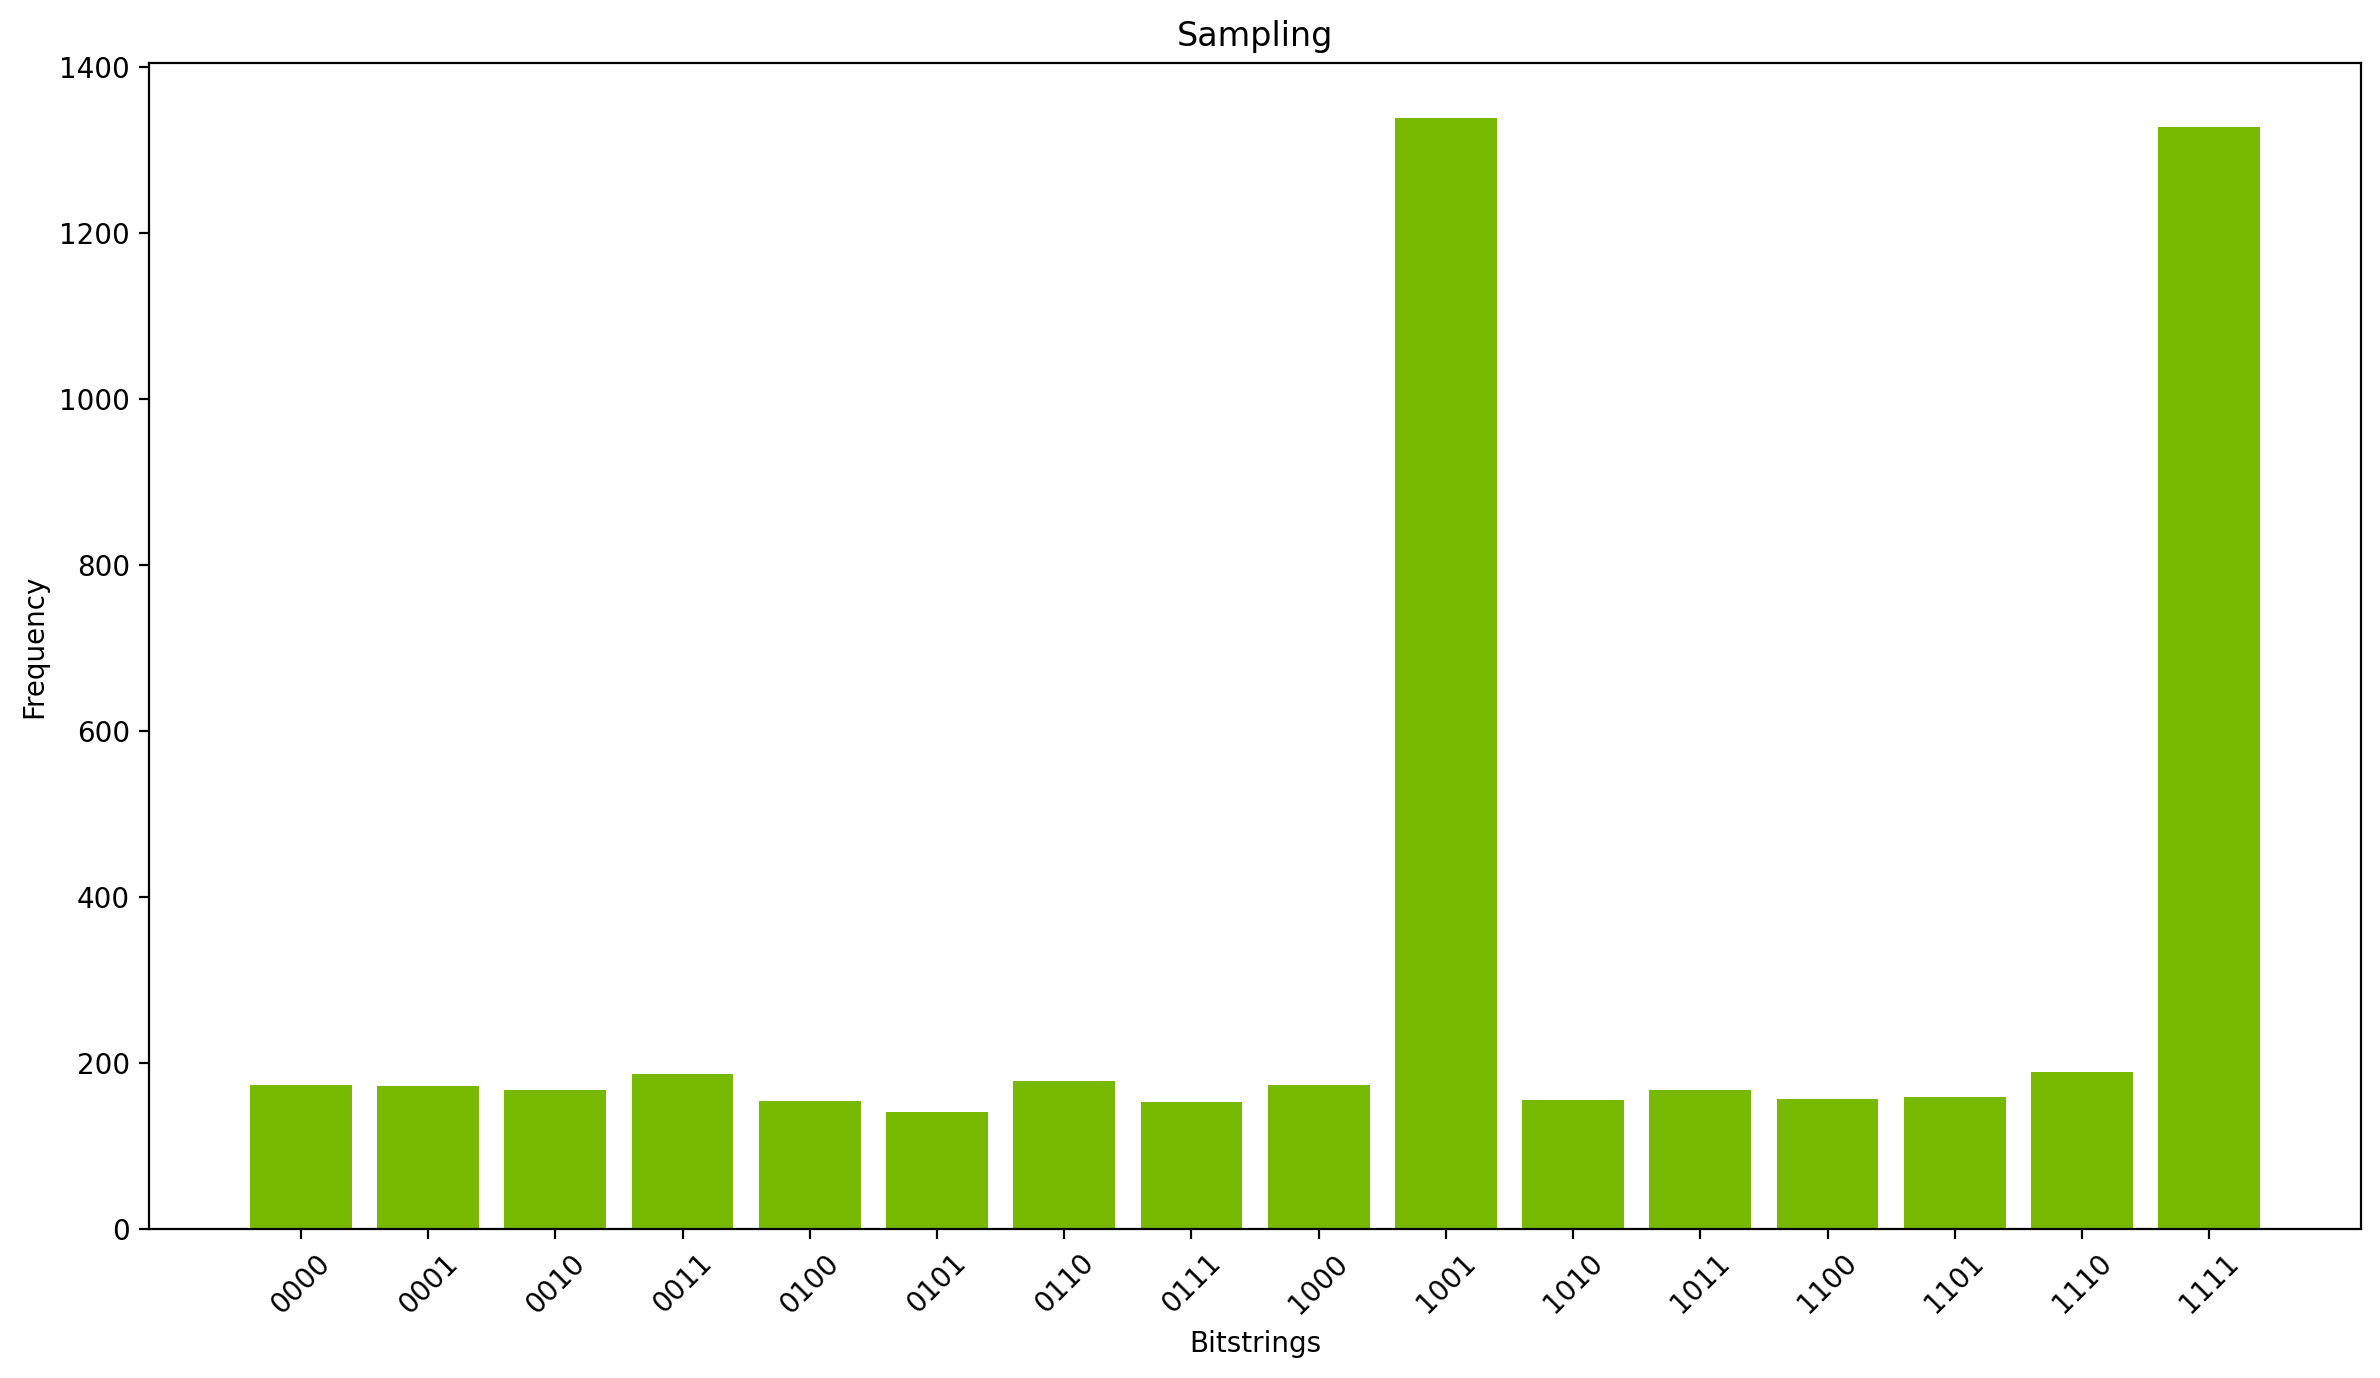

In [11]:
num_qubits = 4    
num_iterations = 2 # CHANGE ME

# Apply the Grover diffusion operation to the equal superposition state
@cudaq.kernel
def grovers(num_qubits: int, num_iterations : int):
    qubits = cudaq.qvector(num_qubits)
    aux_qubit =cudaq.qubit()
    # Initialize qubits in an equal superposition state
    equal_superposition(qubits)
    # Initialize the auxillary qubit in the minus state
    x(aux_qubit)
    h(aux_qubit)    
    # Apply num_iteration iterations of the diffusion operator
    for _ in range(num_iterations):
        phase_oracle(qubits, aux_qubit)
        diffusion_operator(qubits)
    
    # Measure all qubits, except the auxillary qubit
    mz(qubits)


# Sample
sample_result = cudaq.sample(grovers, num_qubits, num_iterations, shots_count = 5000)

print(sample_result)

# Plot the histogram of sampling results
plot_results(sample_result, num_qubits)

As an exercise, adapt the code to search for a different set of unmarked elements on another unstructured database.